# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 8.7 MB/s 
     |████████████████████████████████| 376 kB 30.4 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=b4c74221a1beee55fa0be35ed1615b3606cd8cb67efc06b6d7cf5f8fa9d02357
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=090af324076ac9be2c29d8d7f4aadb336030c52b42ad9ca9578e1221ab6a0be7
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dellmg31
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dellmg31
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 3.82 MiB/s, done.
Resolving deltas: 100% (3/3), done.


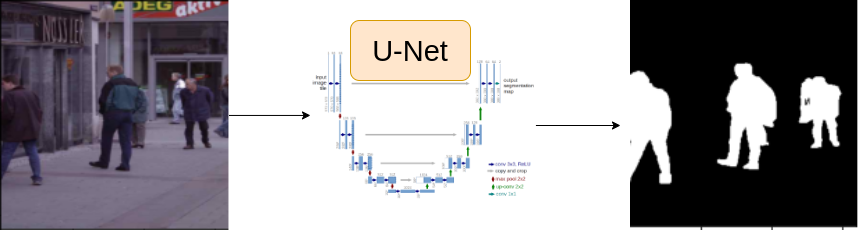

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

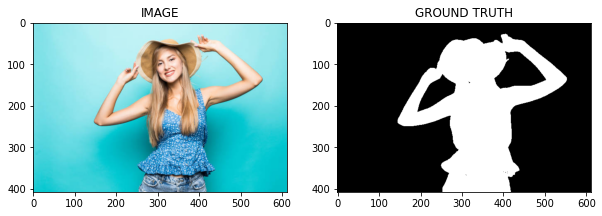

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
from re import I
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
  ])

def get_val_aufs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__ (self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data["image"]
      mask = data["mask"]

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
valset = SegmentationDataset(val_df, get_val_aufs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 232
Size of Validset : 58


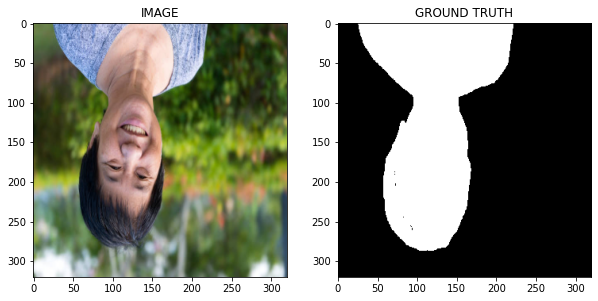

In [ ]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE)

In [ ]:
print(f"total no. of batches in train_loader : {len(train_loader)}")
print(f"total no. of batches in val_loader : {len(val_loader)}")

total no. of batches in train_loader : 15
total no. of batches in val_loader : 4


In [ ]:
for image, mask in train_loader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arch = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.arch(images)

    if masks != None:
      loss1 = DiceLoss(mode="binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
  
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer)
  val_loss = eval_fn(val_loader, model)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED-MODEL")
    best_val_loss = val_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Val_loss : {val_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.27389373183250426 Val_loss : 0.2895527556538582


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.2412236044804255 Val_loss : 0.2488168552517891


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Epoch : 3 Train_loss : 0.2896553526322047 Val_loss : 0.4240095466375351


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch : 4 Train_loss : 0.2732954661051432 Val_loss : 0.2536630779504776


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.1931805282831192 Val_loss : 0.1945330686867237


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


SAVED-MODEL
Epoch : 6 Train_loss : 0.1740603764851888 Val_loss : 0.1866542138159275


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Epoch : 7 Train_loss : 0.1635877658923467 Val_loss : 0.23086602985858917


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch : 8 Train_loss : 0.18233038435379664 Val_loss : 0.27870000153779984


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch : 9 Train_loss : 0.15349874993165333 Val_loss : 0.18875965848565102


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch : 10 Train_loss : 0.12612378597259521 Val_loss : 0.20568948239088058


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch : 11 Train_loss : 0.11896779884894688 Val_loss : 0.22549089416861534


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


SAVED-MODEL
Epoch : 12 Train_loss : 0.11273966481288274 Val_loss : 0.18503829091787338


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Epoch : 13 Train_loss : 0.10313359846671423 Val_loss : 0.2038718145340681


100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Epoch : 14 Train_loss : 0.10924546917279561 Val_loss : 0.23814654909074306


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch : 15 Train_loss : 0.11051099896430969 Val_loss : 0.23336496204137802


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


SAVED-MODEL
Epoch : 16 Train_loss : 0.11173512438933055 Val_loss : 0.1819305457174778


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch : 17 Train_loss : 0.12511448909838993 Val_loss : 0.26699964702129364


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch : 18 Train_loss : 0.10425271838903427 Val_loss : 0.23678486421704292


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Epoch : 19 Train_loss : 0.09572821905215581 Val_loss : 0.23590364679694176


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Epoch : 20 Train_loss : 0.1085480605562528 Val_loss : 0.21242225728929043


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


Epoch : 21 Train_loss : 0.09351486663023631 Val_loss : 0.184505395591259


100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


Epoch : 22 Train_loss : 0.09951362510522206 Val_loss : 0.21127291396260262


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Epoch : 23 Train_loss : 0.1487091784675916 Val_loss : 0.23302511870861053


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


Epoch : 24 Train_loss : 0.1396993969877561 Val_loss : 0.3218420445919037


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

Epoch : 25 Train_loss : 0.11579892237981161 Val_loss : 0.3723156005144119


# Task 9 : Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load("/content/best_model.pt"))
image, mask = valset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

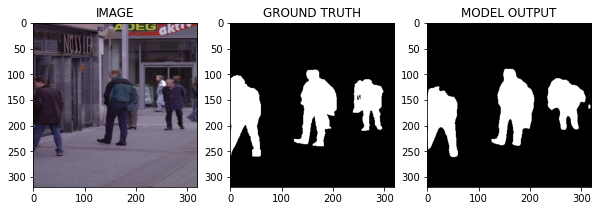

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya